In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from data_processing import get_tabular_dataset2

data_train, data_test = get_tabular_dataset2(save=True)

Loading data... Done.
Creating features... precip t td hu ff dd Done.
Loading data... Done.
Creating features... precip t td hu ff dd Done.


In [2]:
data_train = pd.read_csv("Data/Train/tabular_train.csv")
data_test = pd.read_csv("Data/Test/tabular_test.csv")

In [3]:
from data_processing import add_nbr_precp

data_train = add_nbr_precp(data_train, K=10)

data_train["number_sta"] = data_train["Id"].str.split("_").apply(lambda s: s[0]).astype(int)
for d in range(1,8):
    data_train[f"precip_day-{d}"] = data_train.groupby("number_sta")["precip_cumul"].shift(d)
for d in range(2, 8):
    data_train[f"precip_avg{d}d"] = data_train[["precip_cumul"] + [f"precip_day-{k}" for k in range(1, d)]].mean(axis=1)

# X_station = pd.read_csv("Data/Train/X_station_Train.csv")
# X_station["Id_split"] = X_station["Id"].str.split("_")
# X_station["hour"] = X_station["Id_split"].apply(lambda s: s[-1]).astype(int)
# X_station["Id"] = X_station["Id_split"].apply(lambda s: s[:2]).str.join("_")
# X_station['date'] = pd.to_datetime(X_station['date'])
# X_station["month"] = X_station["date"].dt.month
# data_train = data_train.merge(X_station[["Id", "month"]].groupby("Id").first().reset_index(), on="Id", how="left")

100%|██████████| 730/730 [00:28<00:00, 25.95it/s]


In [4]:
y = np.log(data_train["Ground_truth"] + 1)

In [5]:
data_train = data_train.groupby("number_sta").fillna(method="ffill").fillna(method="bfill")

In [6]:
data_train["Id_split"] = data_train["Id"].str.split("_")
data_train["number_sta"] = data_train["Id_split"].apply(lambda s: s[0]).astype(int)
data_train["day"] = data_train["Id_split"].apply(lambda s: s[1]).astype(int)

In [15]:
# data_train = data_train.drop(columns=["number_sta", "day", "Id_split"])
data_train = data_train.drop(columns=["month_y"])

In [7]:
data_train.sort_values(["number_sta", "day"])[["number_sta", "day", "precip_cumul", "Ground_truth"]]

,number_sta,day,precip_cumul,Ground_truth
0,14066001,0,0.2,3.4
226,14066001,1,3.4,11.7
449,14066001,2,11.7,0.6
671,14066001,3,0.6,0.4
892,14066001,4,0.4,3.0
...,...,...,...,...
161198,95690001,725,2.4,3.2
161424,95690001,726,3.2,0.0
161649,95690001,727,0.0,4.4
161878,95690001,728,4.4,5.4


In [16]:
scale_cols = data_train.columns[1:]
scale_cols

Index(['Ground_truth', 'baseline_obs', 'baseline_pred', 'month_x', 'lat',
       'lon', 'height_sta', 'precip_cumul', 'precip_0', 'precip_1',
       ...
       'precip_day-4', 'precip_day-5', 'precip_day-6', 'precip_day-7',
       'precip_avg2d', 'precip_avg3d', 'precip_avg4d', 'precip_avg5d',
       'precip_avg6d', 'precip_avg7d'],
      dtype='object', length=186)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_train[scale_cols] = scaler.fit_transform(data_train[scale_cols])

In [18]:
n, p = data_train.shape

cnn_features = ["precip", "t", "td", "hu", "ff", "dd"]
x_cnn = np.zeros((n, 24, 6))
for t in range(24):
    for i, feature in enumerate(cnn_features):
        print(t, feature)
        x_cnn[:,t,i] = data_train[f"{feature}_{t}"]

0 precip
0 t
0 td
0 hu
0 ff
0 dd
1 precip
1 t
1 td
1 hu
1 ff
1 dd
2 precip
2 t
2 td
2 hu
2 ff
2 dd
3 precip
3 t
3 td
3 hu
3 ff
3 dd
4 precip
4 t
4 td
4 hu
4 ff
4 dd
5 precip
5 t
5 td
5 hu
5 ff
5 dd
6 precip
6 t
6 td
6 hu
6 ff
6 dd
7 precip
7 t
7 td
7 hu
7 ff
7 dd
8 precip
8 t
8 td
8 hu
8 ff
8 dd
9 precip
9 t
9 td
9 hu
9 ff
9 dd
10 precip
10 t
10 td
10 hu
10 ff
10 dd
11 precip
11 t
11 td
11 hu
11 ff
11 dd
12 precip
12 t
12 td
12 hu
12 ff
12 dd
13 precip
13 t
13 td
13 hu
13 ff
13 dd
14 precip
14 t
14 td
14 hu
14 ff
14 dd
15 precip
15 t
15 td
15 hu
15 ff
15 dd
16 precip
16 t
16 td
16 hu
16 ff
16 dd
17 precip
17 t
17 td
17 hu
17 ff
17 dd
18 precip
18 t
18 td
18 hu
18 ff
18 dd
19 precip
19 t
19 td
19 hu
19 ff
19 dd
20 precip
20 t
20 td
20 hu
20 ff
20 dd
21 precip
21 t
21 td
21 hu
21 ff
21 dd
22 precip
22 t
22 td
22 hu
22 ff
22 dd
23 precip
23 t
23 td
23 hu
23 ff
23 dd


In [20]:
flat_features = [
    "baseline_pred", 
    "lat", "lon", "height_sta",
    "mean_nbr_precip", 
    "precip_day-1","precip_day-2","precip_day-3","precip_day-4","precip_day-5","precip_day-6","precip_day-7",
    #"precip_avg2d", "precip_avg3d", "precip_avg4d", "precip_avg5d", "precip_avg6d", "precip_avg7d", 
    "month"
]
flat_n = len(flat_features)
x_flat = np.zeros((n, flat_n))
for i, feature in enumerate(flat_features):
    x_flat[:,i] = data_train[feature]

In [ ]:
from sklearn.model_selection import train_test_split

X_cnn_train, X_cnn_val, X_flat_train, X_flat_val, y_train, y_val = train_test_split(x_cnn, x_flat, y, test_size=.2)

In [48]:
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Concatenate
from tensorflow.keras.models import Model

def build_model():
    cnn_in = Input(shape=(24, 6))
    x = Conv1D(32, kernel_size=5, activation="relu")(cnn_in)
    x = Conv1D(32, kernel_size=5, activation="relu")(x)
    # x = Conv1D(32, kernel_size=5, activation="relu")(x)
    x1 = Flatten()(x)


    flat_in = Input(shape=(flat_n,))
    x = Dense(16, activation="relu")(flat_in)
    x2 = Dense(16, activation="relu")(x)

    x = Concatenate(axis=-1)([x1, x2])
    x = Dense(32, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    out = Dense(1, activation="linear")(x)

    model = Model(inputs=[cnn_in, flat_in], outputs=out)
    return model

model = build_model()

In [49]:
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

In [51]:
history = model.fit(
    [X_cnn_train, X_flat_train],
    y_train,
    batch_size=100,
    epochs=30,
    validation_data=([X_cnn_val, X_flat_val], y_val)
)

Epoch 1/30
1297/1297 [==============================] - 8s 5ms/step - loss: 0.3183 - val_loss: 0.2635
Epoch 2/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2552 - val_loss: 0.2594
Epoch 3/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2492 - val_loss: 0.2570
Epoch 4/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2459 - val_loss: 0.2515
Epoch 5/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2415 - val_loss: 0.2465
Epoch 6/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2382 - val_loss: 0.2432
Epoch 7/30
1297/1297 [==============================] - 8s 6ms/step - loss: 0.2335 - val_loss: 0.2456
Epoch 8/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2310 - val_loss: 0.2410
Epoch 9/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.2279 - val_loss: 0.2356
Epoch 10/30
1297/1297 [==============================] - 7s 5ms/step - loss: 0.224

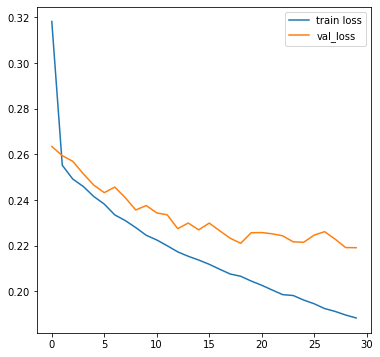

In [52]:
H = history.history

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(H["loss"], label="train loss")
ax.plot(H["val_loss"], label="val_loss")
ax.legend()
plt.show()

In [53]:
model.evaluate([X_cnn_val, X_flat_val], y_val)

1014/1014 [==============================] - 3s 3ms/step - loss: 0.2191


0.21908628940582275

In [54]:
def MAPE(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true+1)))

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)[:,0]
    return 100 - MAPE(np.exp(y) - 1, np.exp(y_pred) - 1)

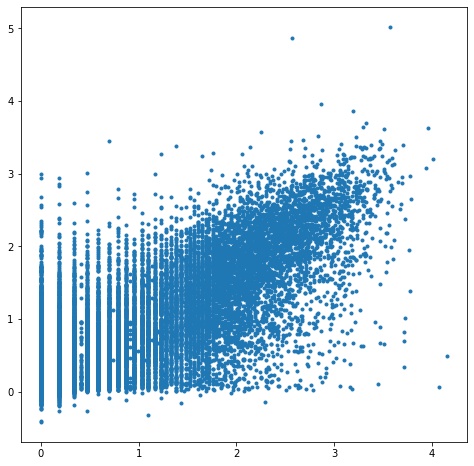

30.448901721983248


In [55]:
y_pred = model.predict([X_cnn_val, X_flat_val])[:,0]

plt.figure(figsize=(8,8))
plt.plot(y_val, y_pred, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_val)-1, np.exp(y_pred)-1)) # previous best: 27.9057

In [56]:
final_model = build_model()
final_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)
final_model.fit(
    [x_cnn, x_flat],
    y,
    batch_size=100,
    epochs=30
)

Epoch 1/30
1622/1622 [==============================] - 8s 5ms/step - loss: 0.3089
Epoch 2/30
1622/1622 [==============================] - 7s 5ms/step - loss: 0.2529
Epoch 3/30
1622/1622 [==============================] - 8s 5ms/step - loss: 0.2476
Epoch 4/30
1622/1622 [==============================] - 7s 4ms/step - loss: 0.2438
Epoch 5/30
1622/1622 [==============================] - 7s 4ms/step - loss: 0.2394
Epoch 6/30
1622/1622 [==============================] - 8s 5ms/step - loss: 0.2355
Epoch 7/30
1622/1622 [==============================] - 8s 5ms/step - loss: 0.2325
Epoch 8/30
1622/1622 [==============================] - 7s 4ms/step - loss: 0.2292
Epoch 9/30
1622/1622 [==============================] - 7s 4ms/step - loss: 0.2259
Epoch 10/30
1622/1622 [==============================] - 7s 4ms/step - loss: 0.2223
Epoch 11/30
1622/1622 [==============================] - 7s 4ms/step - loss: 0.2198
Epoch 12/30
1622/1622 [==============================] - 8s 5ms/step - loss: 0.2174
E

In [57]:
from data_processing import add_nbr_precp

data_test = add_nbr_precp(data_test, K=10)

data_test["number_sta"] = data_test["Id"].str.split("_").apply(lambda s: s[0]).astype(int)
for d in range(1,8):
    data_test[f"precip_day-{d}"] = data_test.groupby("number_sta")["precip_cumul"].shift(d)
for d in range(2, 8):
    data_test[f"precip_avg{d}d"] = data_test[["precip_cumul"] + [f"precip_day-{k}" for k in range(1, d)]].mean(axis=1)

100%|██████████| 363/363 [00:14<00:00, 25.23it/s]


In [58]:
data_test = data_test.groupby("number_sta").fillna(method="ffill").fillna(method="bfill")

In [74]:
data_test[scale_cols] = scaler.transform(data_test[scale_cols])

In [76]:
n, p = data_test.shape

x_cnn_test = np.zeros((n, 24, 6))
for t in range(24):
    for i, feature in enumerate(cnn_features):
        x_cnn_test[:,t,i] = data_test[f"{feature}_{t}"]

In [77]:
flat_n = len(flat_features)
x_flat_test = np.zeros((n, flat_n))
for i, feature in enumerate(flat_features):
    x_flat_test[:,i] = data_test[feature]

In [78]:
final_prediction = final_model.predict([x_cnn_test, x_flat_test])

In [82]:
final_prediction[:,0].shape

(85140,)

In [83]:
submission_df = pd.DataFrame(dict(
    Id = data_test["Id"],
    Prediction = np.exp(final_prediction[:,0])
))
submission_df.to_csv("Submissions/submission_6.csv", index=False)